# 🐍 Join Datasets Notebook Overview
This notebook processes and merges IMDb and TMDB datasets, applying filtering and cleanup.

## 📂 Steps in This Notebook
1️⃣ **Unpacked IMDb Data** → Extracted GZIP files (one-time setup).  
2️⃣ **Loaded IMDb Title Basics** → Dropped unnecessary columns for efficiency.  
3️⃣ **Merged IMDb with Ratings** → Filtered for movies with **>1,000 votes**.  
4️⃣ **Merged Subgenres** → ⚠️ *Issue:* *Gladiator (2000)* got TMDB data from *Gladiator (1992)* (Needs Fixing).  
5️⃣ **Exported Titles for TMDB Data Retrieval** → Processed in `TMDBDataExtractor.ipynb`.  
6️⃣ **Imported & Merged TMDB Data** → Combined IMDb & TMDB metadata.  
7️⃣ **Final Filtering** → Kept **English language** movies with **revenue > $500K** (from **11,072 → 5,440** movies).  

## 📊 Current Dataset Columns
`tconst`, `title`, `year`, `runtime_minutes`, `genres`, `rating`, `numVotes`, `subgenres`, `budget`,  
`TMDB_id`, `origin_country`, `language`, `revenue`, `keywords`, `production_companies`, `cast`, `crew`.

##  🛠️ Next Steps
✔ **Fix *Gladiator* subgenre mismatch**  
✔ **Drop redundant columns (`title_x`, `title_y`, `genres_x`, `genres_y`)**  
✔ **Prepare dataset for graph-building & analysis**  

---

### Unpack (skip this)

In [ ]:
import gzip, shutil
import pandas as pd

with gzip.open('IMDb/new/title.basics.tsv.gz', 'rb') as f_in:
    with open('IMDb/new/title.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('IMDb/new/title.ratings.tsv.gz', 'rb') as f_in:
    with open('IMDb/new/title.ratings.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('IMDb/new/name.basics.tsv.gz', 'rb') as f_in:
    with open('IMDb/new/name.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('IMDb/new/title.akas.tsv.gz', 'rb') as f_in:
    with open('IMDb/new/title.akas.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('IMDb/new/title.crew.tsv.gz', 'rb') as f_in:
    with open('IMDb/new/title.crew.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### Load title_basics data
then filter by year to reduce rows

In [1]:
import pandas as pd
print("here")
df_title_basics = pd.read_csv('IMDb/new/title.basics.tsv', sep='\t', low_memory=False, na_values=['\\N'])
df_title_basics = df_title_basics.rename(columns={"startYear": "year"})

# Keep only rows where 'runtime' contains valid integers
df_title_basics["runtimeMinutes"] = df_title_basics["runtimeMinutes"].fillna("")
df_filtered = df_title_basics[df_title_basics["runtimeMinutes"].str.isdigit()].copy()
df_filtered["runtimeMinutes"] = df_filtered["runtimeMinutes"].astype(int)

df_title_basics_filtered = df_filtered[(df_filtered["year"] >= 1970) &
                                           (df_filtered["titleType"] == "movie") &
                                           (df_filtered["runtimeMinutes"] >= 60) &
                                           (df_filtered["runtimeMinutes"] <= 300)]

df_title_basics_filtered = df_title_basics_filtered.drop(columns=["isAdult", "endYear", "titleType"])
df_title_basics_filtered["year"] = df_title_basics_filtered["year"].astype(int)

df_title_basics_filtered.head()

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,genres
15479,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance"
34794,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance"
35957,tt0036606,"Another Time, Another Place","Another Time, Another Place",1983,118,"Drama,War"
38749,tt0039442,"Habla, mudita","Habla, mudita",1973,88,Drama
44149,tt0044952,Nagarik,Nagarik,1977,127,Drama


### MERGE BASICS WITH RATINGS
then filter by numVotes to further filter

In [2]:
df_title_ratings = pd.read_csv('IMDb/new/title.ratings.tsv', sep='\t', low_memory=False, na_values=['\\N'])

df_merged = pd.merge(df_title_basics_filtered, df_title_ratings, on="tconst", how="inner")

# FILTER FOR POPULAR MOVIES
df_merged_filtered = df_merged[df_merged["numVotes"] > 1000]

print(f"Rows: {len(df_merged_filtered)}")
df_merged_filtered.head()

Rows: 39339


,tconst,primaryTitle,originalTitle,year,runtimeMinutes,genres,averageRating,numVotes
1,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,91466
6,tt0054724,I Eat Your Skin,Zombie,1971,92,Horror,3.6,1733
24,tt0061592,Doomsday Machine,Doomsday Machine,1976,83,Sci-Fi,2.6,1450
30,tt0062690,The Awakening of the Beast,O Ritual dos Sádicos,1970,93,"Drama,Horror",5.9,1368
43,tt0063142,Isle of the Snake People,La muerte viviente,1971,90,"Horror,Mystery",3.4,1095


### MERGE THOSE WITH SUB-GENRES

In [3]:
import ast

df_subgenres = pd.read_csv("IMDb/titles_subgenres.csv")
print(df_subgenres.columns)
df_merged2 = df_subgenres.merge(df_merged_filtered, how="inner", left_on=["title", "year"], right_on=["primaryTitle", "year"])

# CLEAN
df_merged2["subgenres"] = df_merged2["subgenres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_merged2["subgenres_str"] = df_merged2["subgenres"].apply(lambda x: ", ".join(x))
df_merged2 = df_merged2.drop(columns=["subgenres", "primaryTitle"])
df_merged2 = df_merged2.rename(columns={"subgenres_str": "subgenres"})

print(f"Rows: {len(df_merged2)}")
df_merged2.head()

Index(['title', 'year', 'subgenres'], dtype='object')
Rows: 9491


,title,year,tconst,originalTitle,runtimeMinutes,genres,averageRating,numVotes,subgenres
0,Captain America: Brave New World,2025.0,tt14513804,Captain America: Brave New World,118,"Action,Adventure,Sci-Fi",5.9,75784,"action-epic, epic-adventure, epic-sci-fi, supe..."
1,Gladiator II,2024.0,tt9218128,Gladiator II,148,"Action,Adventure,Drama",6.6,215175,"action-epic, epic-adventure, epic-drama, perio..."
2,Furiosa: A Mad Max Saga,2024.0,tt12037194,Furiosa: A Mad Max Saga,148,"Action,Adventure,Sci-Fi",7.5,279232,"action-epic, car-action, desert-adventure, dys..."
3,Dune: Part Two,2024.0,tt15239678,Dune: Part Two,166,"Action,Adventure,Drama",8.5,611472,"action-epic, desert-adventure, epic-drama, epi..."
4,Gladiator,2000.0,tt0172495,Gladiator,155,"Action,Adventure,Drama",8.5,1742974,"action-epic, epic-adventure, epic-drama, perio..."


### EXPORT TITLES FOR FURTHER DATA AQUISITION FROM TMDB

In [4]:
df_merged2[["title", "tconst"]].to_csv("titles_with_subgenres.csv")
print("saved")

saved


### IMPORT JSON DATA

In [5]:
df_tmdb = pd.read_csv("parsed_json_data.csv")
df_tmdb = df_tmdb.rename(columns={"id": "tmdb_id"})
df_tmdb = df_tmdb.drop(["original_title", "keywords", "title", "origin_country", "genres"], axis=1)
print(f"Rows: {len(df_tmdb)}")
df_tmdb.head()

Rows: 11072


,budget,original_language,revenue,production_companies,cast,crew,tconst
0,48000000,en,76019048,"['Konrad Pictures', 'Miramax']","[{'name': 'Meg Ryan', 'order': 0, 'character':...","[{'name': 'James Mangold', 'job': 'Director', ...",tt0035423
1,0,fr,0,"['Les Films La Boétie', 'Euro International Fi...","[{'name': 'Stéphane Audran', 'order': 0, 'char...","[{'name': 'Claude Chabrol', 'job': 'Director',...",tt0064106
2,0,en,0,"['Roxanne Company', 'American International Pi...","[{'name': 'Shirley Stoler', 'order': 0, 'chara...","[{'name': 'Leonard Kastle', 'job': 'Director',...",tt0064437
3,0,en,0,"['Triumvirate Films', 'United Artists']","[{'name': 'Jenny Agutter', 'order': 0, 'charac...","[{'name': 'David Greene', 'job': 'Director', '...",tt0064462
4,0,cs,0,['Filmové studio Barrandov'],"[{'name': 'Elo Romančík', 'order': 0, 'charact...","[{'name': 'Otakar Vávra', 'job': 'Director', '...",tt0064546


### MERGE IMDB & TMDB DATA (CROSSING THE STREAMS)

In [6]:
def merge_tmdb_with_imdb(df_imdb, df_tmdb):
    """Merge TMDB JSON data into the IMDb dataset."""
    # Merge IMDb dataset with extracted TMDB data
    df_merged = pd.merge(df_imdb, df_tmdb, on="tconst")
    
    return df_merged

# Merge TMDB data into IMDb dataset (df_merged2)
df_final = merge_tmdb_with_imdb(df_merged2, df_tmdb)


#df_final.to_csv("merged_imdb_tmdb.csv", index=False)

df_final.tail(1)

,title,year,tconst,originalTitle,runtimeMinutes,genres,averageRating,numVotes,subgenres,budget,original_language,revenue,production_companies,cast,crew
9487,Chrysalis,2014.0,tt2836260,Chrysalis,100,"Drama,Horror,Sci-Fi",4.7,1008,zombie-horror,0,en,0,"['CNGM Pictures', 'FOUR Productions', 'Glass C...","[{'name': 'Sara Gorsky', 'order': 0, 'characte...","[{'name': 'John Klein', 'job': 'Director', 'ge..."


### FILTER

In [7]:
filtered = df_final[
    (df_final["revenue"] >= 500_000) &
    (df_final["original_language"] == "en") &
    (df_final["budget"] > 0)
].copy()

filtered = filtered.drop(["original_language"], axis=1)

rows_after = filtered.shape[0]
rows_before = df_final.shape[0]
print(f"Before: {rows_before}\nAfter: {rows_after}")
filtered.head(1)

Before: 9488
After: 4688


,title,year,tconst,originalTitle,runtimeMinutes,genres,averageRating,numVotes,subgenres,budget,revenue,production_companies,cast,crew
0,Captain America: Brave New World,2025.0,tt14513804,Captain America: Brave New World,118,"Action,Adventure,Sci-Fi",5.9,75784,"action-epic, epic-adventure, epic-sci-fi, supe...",180000000,388056272,"['Marvel Studios', 'Kevin Feige Productions']","[{'name': 'Anthony Mackie', 'order': 0, 'chara...","[{'name': 'Kevin Feige', 'job': 'Producer', 'g..."


In [9]:
import pandas as pd

# Assuming your DataFrame is called df
missing_counts = filtered.isna().sum()

# Display only columns that have at least one missing value
#missing_counts = missing_counts[missing_counts > 0]

print(missing_counts)


title                   0
year                    0
tconst                  0
originalTitle           0
runtimeMinutes          0
genres                  0
averageRating           0
numVotes                0
subgenres               0
budget                  0
revenue                 0
production_companies    0
cast                    0
crew                    0
dtype: int64


### EXPLODE DATA FOR GRAPH

In [33]:
import pandas as pd
import ast

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

df = filtered.copy()

# Create a list of flat relationship rows
flat_rows = []
n_cast = 20

for _, row in df.iterrows():
    # Unpack movie info
    from_movie = {
        'from_label': 'Movie',
        'from_tconst': row['tconst'],
        'from_title': row['title'],
        'from_year': row['year'],
        'from_runtimeMinutes': row['runtimeMinutes'],
        'from_averageRating': row['averageRating'],
        'from_numVotes': row['numVotes'],
        'from_budget': row['budget'],
        'from_revenue': row['revenue']
    }

    # === GENRES ===
    for genre in row['genres'].split(','):
        flat_rows.append({
            **from_movie,
            'relationship': 'IN_GENRE',
            'to_label': 'Genre',
            'to_name': genre.strip(),
            'to_id': None, 'to_gender': None, 'to_popularity': None, 'to_adult': None
        })

    # === SUBGENRES ===
    for subgenre in row['subgenres'].split(', '):
        flat_rows.append({
            **from_movie,
            'relationship': 'HAS_SUBGENRE',
            'to_label': 'Subgenre',
            'to_name': subgenre.strip(),
            'to_id': None, 'to_gender': None, 'to_popularity': None, 'to_adult': None
        })

    # === PRODUCTION COMPANIES ===
    companies = ast.literal_eval(row['production_companies']) if isinstance(row['production_companies'], str) else row['production_companies']
    for company in companies:
        flat_rows.append({
            **from_movie,
            'relationship': 'PRODUCED_BY',
            'to_label': 'ProductionCompany',
            'to_name': company,
            'to_id': None, 'to_gender': None, 'to_popularity': None, 'to_adult': None
        })

    # === CAST (Actors) ===
    cast_list = ast.literal_eval(row['cast']) if isinstance(row['cast'], str) else row['cast']
    for actor in cast_list:
        if int(actor.get('order', 999)) <= n_cast:
            flat_rows.append({
                **from_movie,
                'relationship': 'ACTED_IN',
                'to_label': 'Actor',
                'to_name': actor.get('name'),
                'to_id': actor.get('id'),
                'to_gender': actor.get('gender'),
                'to_popularity': actor.get('popularity'),
                'to_adult': actor.get('adult')
            })

    # === CREW (Directors, Producers, DP) ===
    relevant_jobs = {'Director': 'DIRECTED', 'Producer': 'PRODUCED', 'Director of Photography': 'PHOTOGRAPHED'}
    crew_list = ast.literal_eval(row['crew']) if isinstance(row['crew'], str) else row['crew']
    for crew in crew_list:
        job = crew.get('job')
        if job in relevant_jobs:
            flat_rows.append({
                **from_movie,
                'relationship': relevant_jobs[job],
                'to_label': job,
                'to_name': crew.get('name'),
                'to_id': crew.get('id'),
                'to_gender': crew.get('gender'),
                'to_popularity': crew.get('popularity'),
                'to_adult': None  # Crew members don't have this field
            })

# === Create flat DataFrame ===
exploded_df = pd.DataFrame(flat_rows)

# Optional: Fill missing values with empty strings to avoid NaNs in CSV
exploded_df = exploded_df.fillna('')

# === Save as Neo4j-ready CSV ===
exploded_df.to_csv('graph_data.csv', index=False)

# Preview first rows
exploded_df.head()


,from_label,from_tconst,from_title,from_year,from_runtimeMinutes,from_averageRating,from_numVotes,from_budget,from_revenue,relationship,to_label,to_name,to_id,to_gender,to_popularity,to_adult
0,Movie,tt14513804,Captain America: Brave New World,2025.0,118,5.9,75784,180000000,388056272,IN_GENRE,Genre,Action,,,,
1,Movie,tt14513804,Captain America: Brave New World,2025.0,118,5.9,75784,180000000,388056272,IN_GENRE,Genre,Adventure,,,,
2,Movie,tt14513804,Captain America: Brave New World,2025.0,118,5.9,75784,180000000,388056272,IN_GENRE,Genre,Sci-Fi,,,,
3,Movie,tt14513804,Captain America: Brave New World,2025.0,118,5.9,75784,180000000,388056272,HAS_SUBGENRE,Subgenre,action-epic,,,,
4,Movie,tt14513804,Captain America: Brave New World,2025.0,118,5.9,75784,180000000,388056272,HAS_SUBGENRE,Subgenre,epic-adventure,,,,


### UNEXPLODE DATA

In [36]:
df = exploded_df.copy()

# Separate out rows for each type of relationship
genre_df = df[df["to_label"] == "Genre"].groupby("from_tconst")["to_name"].apply(lambda x: ', '.join(sorted(set(x)))).reset_index(name="genres")
subgenre_df = df[df["to_label"] == "Subgenre"].groupby("from_tconst")["to_name"].apply(lambda x: ', '.join(sorted(set(x)))).reset_index(name="subgenres")

# Get unique movie metadata
movie_metadata = df.groupby("from_tconst").first().reset_index()

# Merge everything back
df_unexploded = movie_metadata.merge(genre_df, on="from_tconst", how="left")
df_unexploded = df_unexploded.merge(subgenre_df, on="from_tconst", how="left")

# Optional: drop extra columns like unrelated to_name or to_label if needed
#df_unexploded = df_unexploded.drop(columns=["to_name", "to_label"])

# Save to CSV
df_unexploded.to_csv("unexploded_data.csv", index=False)


df_unexploded.head(5)

,from_tconst,from_label,from_title,from_year,from_runtimeMinutes,from_averageRating,from_numVotes,from_budget,from_revenue,relationship,to_label,to_name,to_id,to_gender,to_popularity,to_adult,genres,subgenres
0,tt0035423,Movie,Kate & Leopold,2001.0,118,6.4,91466,48000000,76019048,IN_GENRE,Genre,Comedy,,,,,"Comedy, Fantasy, Romance",feel-good-romance
1,tt0065134,Movie,Two Mules for Sister Sara,1970.0,116,7.0,31918,2500000,5050000,IN_GENRE,Genre,Adventure,,,,,"Adventure, Drama, Romance",quest-adventure
2,tt0065377,Movie,Airport,1970.0,137,6.6,22999,10000000,100489151,IN_GENRE,Genre,Action,,,,,"Action, Drama, Thriller","dark-comedy, disaster-action"
3,tt0065462,Movie,Beneath the Planet of the Apes,1970.0,95,6.0,55550,3000000,18999718,IN_GENRE,Genre,Action,,,,,"Action, Adventure, Sci-Fi",dystopian-sci-fi
4,tt0065466,Movie,Beyond the Valley of the Dolls,1970.0,109,6.1,12467,2090000,9000000,IN_GENRE,Genre,Comedy,,,,,"Comedy, Drama, Music","parody-comedy, satire-comedy"


### ADJUST FOR INFLATION & DISCRITIZE

In [37]:
import pandas as pd
import cpi

# Make sure CPI data is loaded
#cpi.update()

# Adjust budget to 2023 dollars
df_unexploded = pd.read_csv("unexploded_data.csv")

# Convert to numeric first, forcing errors to NaN, then dropna and cast to int
df_unexploded["from_year"] = pd.to_numeric(df_unexploded["from_year"], errors="coerce").dropna().astype(int)
df_unexploded["from_budget"] = pd.to_numeric(df_unexploded["from_budget"], errors="coerce")
df_unexploded["from_revenue"] = pd.to_numeric(df_unexploded["from_revenue"], errors="coerce")
df_unexploded["from_year_adj"] = df_unexploded["from_year"].clip(upper=2023).astype(int)

df_unexploded["from_budget_adj"] = df_unexploded.apply(
    lambda row: cpi.inflate(row["from_budget"], row["from_year_adj"], to=2023) if pd.notnull(row["from_budget"]) else None,
    axis=1
)

# Adjust revenue to 2023 dollars
df_unexploded["from_revenue_adj"] = df_unexploded.apply(
    lambda row: cpi.inflate(row["from_revenue"], row["from_year_adj"], to=2023) if pd.notnull(row["from_revenue"]) else None,
    axis=1
)

df_unexploded.head()

,from_tconst,from_label,from_title,from_year,from_runtimeMinutes,from_averageRating,from_numVotes,from_budget,from_revenue,relationship,to_label,to_name,to_id,to_gender,to_popularity,to_adult,genres,subgenres,from_year_adj,from_budget_adj,from_revenue_adj
0,tt0035423,Movie,Kate & Leopold,2001,118,6.4,91466,48000000,76019048,IN_GENRE,Genre,Comedy,NaN,NaN,NaN,NaN,"Comedy, Fantasy, Romance",feel-good-romance,2001,8.258439e+07,1.307914e+08
1,tt0065134,Movie,Two Mules for Sister Sara,1970,116,7.0,31918,2500000,5050000,IN_GENRE,Genre,Adventure,NaN,NaN,NaN,NaN,"Adventure, Drama, Romance",quest-adventure,1970,1.963286e+07,3.965838e+07
2,tt0065377,Movie,Airport,1970,137,6.6,22999,10000000,100489151,IN_GENRE,Genre,Action,NaN,NaN,NaN,NaN,"Action, Drama, Thriller","dark-comedy, disaster-action",1970,7.853144e+07,7.891558e+08
3,tt0065462,Movie,Beneath the Planet of the Apes,1970,95,6.0,55550,3000000,18999718,IN_GENRE,Genre,Action,NaN,NaN,NaN,NaN,"Action, Adventure, Sci-Fi",dystopian-sci-fi,1970,2.355943e+07,1.492075e+08
4,tt0065466,Movie,Beyond the Valley of the Dolls,1970,109,6.1,12467,2090000,9000000,IN_GENRE,Genre,Comedy,NaN,NaN,NaN,NaN,"Comedy, Drama, Music","parody-comedy, satire-comedy",1970,1.641307e+07,7.067830e+07


| category               | lower bound (usd) | upper bound (usd) |
|------------------------|-------------------|-------------------|
| indie                    | 0        | 2M         |
| low                    | 2M         | 20M        |
| medium                 | 20M        | 50M        |
| high                   | 50M        | 100M       |
| tentpole               | 100M       | ∞          |


In [41]:
# discritize budget
# Define bin edges and labels
budget_bins = [0, 2_000_000, 20_000_000, 50_000_000, 100_000_000, float("inf")]

budget_labels = [
    "indie",
    "low",
    "medium",
    "high",
    "tentpole"
]

# Apply discretization
df_unexploded["from_budget_category"] = pd.cut(
    df_unexploded["from_budget_adj"],
    bins=budget_bins,
    labels=budget_labels,
    right=False  # means intervals are [), e.g. 0 <= x < 20,000
)

print(df_unexploded["from_budget_category"].value_counts())

# discritize profit
df_unexploded['profit'] = df_unexploded['from_revenue_adj'] - df_unexploded['from_budget_adj']

df_unexploded['profit_percent_gain'] = 100 * df_unexploded['profit'] / df_unexploded['from_budget_adj']

df_unexploded.to_csv("../data/poster3_data.csv")

from_budget_category
medium      1480
low         1135
high        1060
tentpole     903
indie        110
Name: count, dtype: int64


In [28]:
# prep for fmm
df = df_unexploded.copy()
#print(df.columns)

# One-hot encode categorical features
from sklearn.preprocessing import MultiLabelBinarizer

# Genres
mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df_unexploded["genres"]), columns=[f"genre_{g}" for g in mlb_genre.classes_])

# Subgenres
mlb_subgenre = MultiLabelBinarizer()
subgenre_encoded = pd.DataFrame(mlb_subgenre.fit_transform(df_unexploded["subgenres"]), columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_])

# Select numeric features
df_numeric = df[["from_runtimeMinutes", "from_averageRating", "from_numVotes", "from_budget", "from_revenue"]]

# Concatenate everything
X = pd.concat([df_numeric.reset_index(drop=True), genre_encoded, subgenre_encoded], axis=1).dropna()

# Scale the full feature matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit GMM
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=20, random_state=0)
gmm.fit(X_scaled)

print(f"AIC: {gmm.aic(X_scaled):,.0f}")
print(f"BIC: {gmm.bic(X_scaled):,.0f}")


AIC: -981,902
BIC: -670,240


In [29]:
gmm = GaussianMixture(n_components=30, random_state=0)
gmm.fit(X_scaled)

print(f"AIC: {gmm.aic(X_scaled):,.0f}")
print(f"BIC: {gmm.bic(X_scaled):,.0f}")


AIC: -1,201,500
BIC: -734,004


In [30]:
gmm = GaussianMixture(n_components=50, random_state=0)
gmm.fit(X_scaled)

print(f"AIC: {gmm.aic(X_scaled):,.0f}")
print(f"BIC: {gmm.bic(X_scaled):,.0f}")


AIC: -1,334,961
BIC: -555,796


In [31]:
gmm = GaussianMixture(n_components=200, random_state=0)
gmm.fit(X_scaled)

print(f"AIC: {gmm.aic(X_scaled):,.0f}")
print(f"BIC: {gmm.bic(X_scaled):,.0f}")


AIC: -1,612,017
BIC: 1,504,660


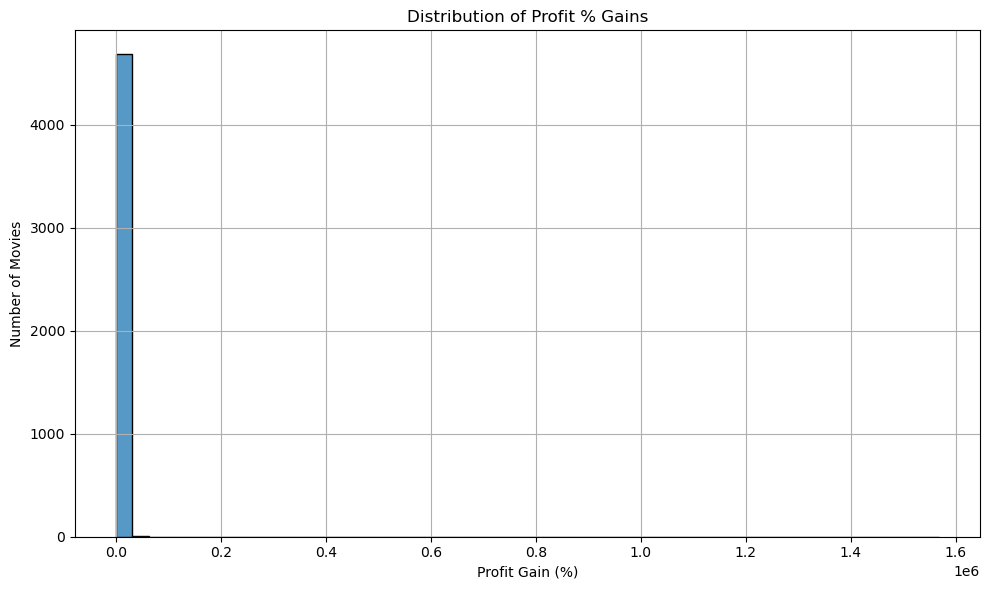

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))
sns.histplot(df_unexploded['profit_percent_gain'], bins=50, kde=False)

plt.title('Distribution of Profit % Gains')
plt.xlabel('Profit Gain (%)')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
df_unexploded['profit_percent_gain'].describe()

count    4.688000e+03
mean     8.290584e+02
std      2.377444e+04
min     -9.939066e+01
25%     -6.223197e+00
50%      1.128987e+02
75%      3.268114e+02
max      1.567431e+06
Name: profit_percent_gain, dtype: float64

### DEBUG

In [19]:
import pandas as pd
import ast

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

########################################
# 1. Start from 'filtered' DataFrame
########################################
df = filtered.copy()

# Create an empty list to store relationship data
relationships = []

for idx, row in df.iterrows():
    # Build the 'movie_node' dictionary (source node)
    movie_node = {
        'label': 'Movie',
        'title': row['title'],
        'tconst': row['tconst'],
        'year': row['year'],
        'runtimeMinutes': row['runtimeMinutes'],
        'averageRating': row['averageRating'],
        'numVotes': row['numVotes'],
        'budget': row['budget'],
        'revenue': row['revenue']
    }

    # Genres
    for genre in row['genres'].split(','):
        genre_node = {'label': 'Genre', 'name': genre}
        relationships.append((movie_node, 'IN_GENRE', genre_node))

    # Sub-genres
    for subgenre in row['subgenres'].split(', '):
        subgenre_node = {'label': 'Subgenre', 'name': subgenre}
        relationships.append((movie_node, 'HAS_SUBGENRE', subgenre_node))

    # Production companies
    companies_list = ast.literal_eval(row['production_companies']) if isinstance(row['production_companies'], str) else row['production_companies']
    for company in companies_list:
        company_node = {'label': 'ProductionCompany', 'name': company}
        relationships.append((movie_node, 'PRODUCED_BY', company_node))

    # Top 6 actors by 'order' field
    cast_list = ast.literal_eval(row['cast']) if isinstance(row['cast'], str) else row['cast']
    top_cast = [actor['name'] for actor in cast_list if int(actor['order']) <= 5]
    for actor_name in top_cast:
        actor_node = {'label': 'Actor', 'name': actor_name}
        relationships.append((actor_node, 'ACTED_IN', movie_node))

    # Crew members (director, producer, director of photography)
    relevant_jobs = {'Director': 'DIRECTED',
                     'Producer': 'PRODUCED',
                     'Director of Photography': 'PHOTOGRAPHED'}

    crew_list = ast.literal_eval(row['crew']) if isinstance(row['crew'], str) else row['crew']
    for crew_member in crew_list:
        if isinstance(crew_member, dict):
            job = crew_member.get('job', None)
            if job in relevant_jobs:
                crew_node = {'label': job.replace(' ', ''), 'name': crew_member['name']}
                relationships.append((crew_node, relevant_jobs[job], movie_node))

# Create the final DataFrame in long format
exploded_df = pd.DataFrame(relationships, columns=['node_from', 'relationship', 'node_to'])

##############################################################
# 2. Flatten dictionaries (node_from, node_to) into columns
##############################################################
def extract_properties(node):
    """Extracts label and properties from a node dictionary"""
    if isinstance(node, dict):
        return (
            node.get('label', None),
            node.get('title', node.get('name', None)),
            node.get('tconst', None),
            node.get('year', None),
            node.get('runtimeMinutes', None),
            node.get('averageRating', None),
            node.get('numVotes', None),
            node.get('budget', None),
            node.get('revenue', None)
        )
    return (None, None, None, None, None, None, None, None, None)

exploded_df[[
    'node_to_label',
    'node_to_name',
    'node_to_tconst',
    'node_to_year',
    'node_to_runtimeMinutes',
    'node_to_averageRating',
    'node_to_numVotes',
    'node_to_budget',
    'node_to_revenue'
]] = exploded_df.apply(
    lambda x: extract_properties(x['node_to']),
    axis=1,
    result_type='expand'
)


exploded_df[['node_to_label', 'node_to_name']] = exploded_df.apply(
    lambda x: extract_properties(x['node_to'])[:2], axis=1, result_type='expand'
)

# Drop the original dictionary columns
exploded_df.drop(columns=['node_from', 'node_to'], inplace=True)

##############################################################
# 3. Merge back to fill 'node_to_tconst' for movies (TITLE + YEAR)
##############################################################
exploded_df['node_to_tconst'] = None

# We unify (title, year) -> tconst from 'filtered'.
# If duplicates exist for same (title, year) with different tconst,
# we'll keep the first or handle them as needed.
filtered_unique = filtered.drop_duplicates(subset=['title', 'year'], keep='first')

mask_is_movie = exploded_df['node_to_label'].eq('Movie')

temp = exploded_df[mask_is_movie].merge(
    filtered_unique[['title', 'year', 'tconst']],
    how='left',
    left_on=['node_to_name', 'node_to_year'],  # <-- Use node_to_year
    right_on=['title', 'year'],
    suffixes=('', '_filtered')
)


# If the merged tconst is not null, copy it into node_to_tconst
temp_mask = temp['tconst'].notnull()
temp.loc[temp_mask, 'node_to_tconst'] = temp.loc[temp_mask, 'tconst']

# Put that info back into exploded_df
exploded_df.loc[temp.index, 'node_to_tconst'] = temp['node_to_tconst'].values

##############################################################
# 4. Save final CSV
##############################################################
exploded_df.to_csv("graph_data.csv", index=False)

print("Final 'graph_data.csv' created, merging on both (title, year).")
print(exploded_df.head(25))


Final 'graph_data.csv' created, merging on both (title, year).
    relationship      node_to_label                      node_to_name node_to_tconst  node_to_year  node_to_runtimeMinutes  node_to_averageRating  node_to_numVotes  node_to_budget  node_to_revenue
0       IN_GENRE              Genre                            Action     tt14513804           NaN                     NaN                    NaN               NaN             NaN              NaN
1       IN_GENRE              Genre                         Adventure     tt14513804           NaN                     NaN                    NaN               NaN             NaN              NaN
2       IN_GENRE              Genre                            Sci-Fi     tt14513804           NaN                     NaN                    NaN               NaN             NaN              NaN
3   HAS_SUBGENRE           Subgenre                       action-epic     tt14513804           NaN                     NaN                    NaN    

In [8]:
import pandas as pd

# Assume exploded_df is already loaded
# Filter for people (rows where to_id and to_name are both non-null)
people_df = exploded_df[(exploded_df['to_id'].notna()) & (exploded_df['to_name'].notna())]

# Sample a handful of names and IDs
sampled_names = people_df['to_name'].dropna().unique()
sampled_ids = people_df['to_id'].dropna().unique()

sampled_names = pd.Series(sampled_names).sample(n=25, random_state=42)
sampled_ids = pd.Series(sampled_ids).sample(n=25, random_state=42)

# Check if each name maps to exactly one ID
name_to_ids = people_df[people_df['to_name'].isin(sampled_names)][['to_name', 'to_id']].drop_duplicates()
name_counts = name_to_ids.groupby('to_name')['to_id'].nunique().reset_index()
name_violations = name_counts[name_counts['to_id'] > 1]

# Check if each ID maps to exactly one name
id_to_names = people_df[people_df['to_id'].isin(sampled_ids)][['to_id', 'to_name']].drop_duplicates()
id_counts = id_to_names.groupby('to_id')['to_name'].nunique().reset_index()
id_violations = id_counts[id_counts['to_name'] > 1]

# Print results
print("Names with multiple TMDB IDs (should be empty):")
print(name_violations)

print("\nIDs mapped to multiple names (should be empty):")
print(id_violations)


Names with multiple TMDB IDs (should be empty):
Empty DataFrame
Columns: [to_name, to_id]
Index: []

IDs mapped to multiple names (should be empty):
Empty DataFrame
Columns: [to_id, to_name]
Index: []


In [ ]:
exploded_df.columns

In [ ]:
bad_row_mask = (
    (exploded_df['node_to_name'] == "Captain America: Brave New World") &
    (exploded_df['node_to_tconst'] == "tt9218128")
)
bad_rows = exploded_df[bad_row_mask]
print(bad_rows)

In [ ]:
# 1) Identify the incorrect rows
wrong_mask = (
    (exploded_df['node_to_label'] == 'Movie') &
    (exploded_df['node_to_name'] == 'Captain America: Brave New World') &
    (exploded_df['node_to_tconst'] == 'tt9218128')
)

# 2) Overwrite them with the correct ID
exploded_df.loc[wrong_mask, 'node_to_tconst'] = 'tt14513804'

# Now rows 10 through 18 will have node_to_tconst = 'tt14513804' (the correct ID).
# 3) (Optional) re-save the CSV
exploded_df.to_csv("graph_data.csv", index=False)

print("Fixed Captain America: Brave New World to use tconst=tt14513804 where it was mistakenly tt9218128.")
